In [83]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [84]:
endHourForCurrentYear = 8736

In [85]:
N = 100

In [86]:
ON_random = [np.sort(np.random.randint(low=0,high=10,size=(endHourForCurrentYear,2)),axis=1) for i in range(N)]

In [87]:
d = [randint(2,50) for i in range(N)]

In [88]:
def orignal_algorithm(ON_min,ON_max,maxDurationON):
    ON_opt = np.zeros(endHourForCurrentYear)
    ON_opt[0] = ON_min[0]

    h = 0 + 1
    while (h < endHourForCurrentYear):
        if (ON_min[h] >= ON_opt[h - 1]):
            ON_opt[h] = ON_min[h]
            h += 1
        else :
            portee = 0
            nivmin = ON_min[h]

            if (ON_max[h] < ON_opt[h - 1]):
                nivmax = ON_max[h] 
            else: 
                nivmax = ON_opt[h - 1]

            if (nivmax > nivmin):
                for k in range(1,maxDurationON+1): 
                    if (h + k >= endHourForCurrentYear):
                        break
                    if (ON_max[h + k] <= ON_min[h]):
                        nivmax = ON_min[h]
                        break
                    if (ON_max[h + k] < nivmax):
                        nivmax = ON_max[h + k]
                        if (nivmax < nivmin):
                            break
                    if (ON_min[h + k] > ON_min[h]):
                        if (ON_min[h + k] >= nivmax):
                            nivmin = nivmax
                            portee = k
                            break
                        elif (ON_min[h + k] >= nivmin):
                            portee = k 
                            nivmin= ON_min[h + k]

            if (portee == 0):
                ON_opt[h] = ON_min[h]
                h+=1               
            else:
                for k in range(portee):
                    ON_opt[h + k] = nivmin
                h += portee
    assert np.all(ON_min<=ON_opt)
    assert np.all(ON_max>=ON_opt)
    return ON_opt

In [89]:
ON_original = [orignal_algorithm(ON_random[i][:,0],ON_random[i][:,1],d[i]) for i in range(N)]

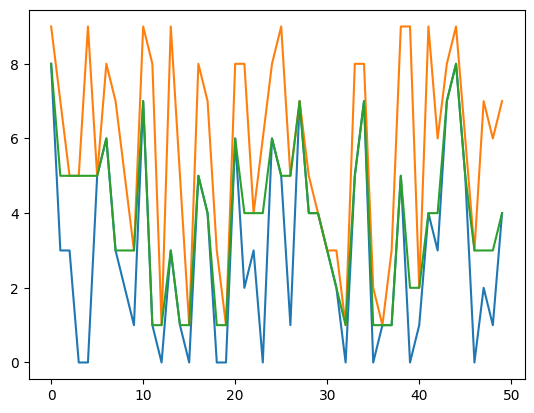

In [90]:
t_min = 0
t_max = 50
for i in range(1):
    plt.figure()
    plt.plot(ON_random[i][t_min:t_max,0])
    plt.plot(ON_random[i][t_min:t_max,1])
    plt.plot(ON_original[i][t_min:t_max])
    plt.show()

In [91]:
def simplified_algorithm(ON_min,ON_max,maxDurationON):
    ON_opt = np.zeros(endHourForCurrentYear)
    ON_opt[0] = ON_min[0]

    h = 0 + 1
    while (h < endHourForCurrentYear):
        if (ON_min[h] >= ON_opt[h - 1]):
            ON_opt[h] = ON_min[h]
            h += 1
        else :
            portee = 0
            nivmin = ON_min[h]
            nivmax = min(ON_max[h],ON_opt[h - 1])

            for k in range(1,min(maxDurationON+1,endHourForCurrentYear-h)):
                nivmax = min(ON_max[h + k],nivmax) # mise à jour du niveau maximum 
                if (nivmin >= nivmax): # on ne pourra pas aller plus loin que la portee calculée précedemment car le niveau max devient trop petit par rapport au niveau min
                    break 
                if (ON_min[h + k] >= nivmin): # on va pouvoir remonter le nombre d'unités à au moins niveau min au moins sur l'intervalle [h,h+k-1]
                    portee = k 
                nivmin= min(max(ON_min[h + k],nivmin),nivmax) # mise à jour du niveau minimum 

                        

            if (portee == 0):
                ON_opt[h] = ON_min[h]
                h+=1               
            else:
                for k in range(portee):
                    ON_opt[h + k] = nivmin
                h += portee
    assert np.all(ON_min<=ON_opt)
    assert np.all(ON_max>=ON_opt)
    return ON_opt

In [92]:
ON_simplied = [simplified_algorithm(ON_random[i][:,0],ON_random[i][:,1],d[i]) for i in range(N)]

In [93]:
for i in range(len(ON_original)):
    assert np.all(ON_original[i]==ON_simplied[i])

In [13]:
%timeit [simplified_algorithm(ON_random[i][:,0],ON_random[i][:,1],d[i]) for i in range(N)]

1.52 s ± 44.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit [orignal_algorithm(ON_random[i][:,0],ON_random[i][:,1],d[i]) for i in range(N)]

1.52 s ± 53.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [115]:
import xpress as xp
xp.controls.outputlog = 1
xp.controls.miprelstop = 1e-10

In [120]:
def optimization_problem(on_min, on_max, d):
    p = xp.problem()

    on = [xp.var(lb=on_min[i],ub=on_max[i],vartype=xp.integer) for i in range(endHourForCurrentYear)]
    m_plus = [xp.var(lb=0,vartype=xp.integer) for i in range(endHourForCurrentYear)]

    p.addVariable(on,m_plus)

    p.addConstraint(on[i-1] - on[i]+m_plus[i] >= 0 for i in range(1,endHourForCurrentYear))
    p.addConstraint(on[0]==on_min[0])

    p.setObjective(xp.Sum([on[i] for i in range (endHourForCurrentYear)])+xp.Sum([(d+0.01)*m_plus[i] for i in range (endHourForCurrentYear)]))

    p.solve()

    return p.getSolution(on)

In [121]:
ON_optimization = [optimization_problem(ON_random[i][:,0],ON_random[i][:,1],d[i]) for i in range(N)]

FICO Xpress v8.14.8, Hyper, solve started 15:16:36, Nov 5, 2024
Heap usage: 7947KB (peak 7947KB, 1746KB system)
Minimizing MILP noname using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
MIPRELSTOP = 1.e-10
Original problem has:
      8736 rows        17472 cols        26206 elements     17472 globals
Presolved problem has:
      2333 rows         5367 cols         6940 elements      5367 globals
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 10MB (peak 17MB, 1746KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  9.00e+00] / [ 1.00e+00,  9.00e+00]
  Objective      [min,max] : [ 1.00e+00,  7.01e+00] / [ 1.00e+00,  8.01e+00]
Autoscaling applied standard scaling

Symmetric problem: generators: 45, support set: 329
 Number of orbits: 139, largest orbit: 5
 Row orbits: 54, row supp

In [122]:
for i in range(len(ON_original)):
    assert np.all(ON_original[i]==ON_optimization[i])